In [1]:
#Challenge 1
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 100)


df0504=pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190504.txt')
df0511=pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190511.txt')
df0518=pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190518.txt')
df0525=pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190525.txt')
dfinitial=pd.concat([df0504,df0511,df0518,df0525]).reset_index(drop=True)


In [2]:
df=dfinitial
for col in df.columns:
    df = df.rename(columns={col: col.rstrip()})

In [3]:
#Challenge 2, plus other date stuff for later challenges
df=df[df['TIME'].str.contains('00:00')]
df['DATETIME']=df['DATE']+' '+df['TIME']
df['DATETIME']=pd.to_datetime(df['DATETIME'])
df['DATE']=pd.to_datetime(df['DATE'])
df['TIME']=pd.to_datetime(df['TIME'],format= '%H:%M:%S' ).dt.time
df['HOUR']=pd.to_datetime(df['TIME'],format= '%H:%M:%S' ).dt.hour
df['WEEK OF YEAR']=df['DATETIME'].dt.weekofyear
df['DAY OF WEEK']=df['DATETIME'].dt.dayofweek.astype('int')
df['WEEKEND']=(df['DAY OF WEEK']==5)|(df['DAY OF WEEK']==6)



In [4]:
def sort(word): 
    char_list = [char for char in str(word)]
    sorted_word = "".join(sorted(char_list))
    return sorted_word
df['LINENAME'] = df['LINENAME'].apply(sort)

In [5]:
df['STATION LINE'] = df['STATION'] + "-" + df['LINENAME']

In [6]:
dfhourly=df.copy()
dfdaily=df.copy()

In [7]:
#Challenge 3
#df=df[df['TIME']=='00:00:00'] not all turnstiles will have a midnight entry
dfdaily=dfdaily.groupby(["C/A", "UNIT", "SCP", "DATE", 'STATION LINE'],as_index=False).first()
dfdaily.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION LINE","DATE"], inplace=True)
dfdaily['NET ENTRIES']=abs(dfdaily.groupby(['C/A','UNIT','SCP','STATION LINE'])['ENTRIES'].diff(-1)*-1)
dfdaily['NET EXITS']=abs(dfdaily.groupby(["C/A", "UNIT", "SCP", 'STATION LINE'])['EXITS'].diff(-1)*-1)
dfdaily['DAYS DIFF']=dfdaily.groupby(["C/A", "UNIT", "SCP", "STATION LINE"])['DATE'].diff(-1)*-1
dfdaily=dfdaily[dfdaily['NET ENTRIES']<50000]
dfdaily.head()
dfdaily['DAYS DIFF'].value_counts()
dfdaily['DAYS DIFF']=dfdaily['DAYS DIFF'].dt.days
dfdaily['NET ENTRIES']=dfdaily['NET ENTRIES']//dfdaily['DAYS DIFF']
dfdaily['NET EXITS']=dfdaily['NET EXITS']//dfdaily['DAYS DIFF']
dfdaily['NET MOVEMENT']=dfdaily['NET ENTRIES']+dfdaily['NET EXITS']
dfdaily.dropna(inplace=True)

#Optimization- deal with resetting counters in a better way

In [8]:
dfdaily['NET ENTRIES'].sort_values()

124462        0.0
74542         0.0
74541         0.0
74540         0.0
74539         0.0
           ...   
92154     26076.0
26689     28517.0
10194     34006.0
26675     38364.0
16602     43080.0
Name: NET ENTRIES, Length: 119899, dtype: float64

In [ ]:
#Challenge 4
logic=(dfdaily['C/A']=='A002')&(dfdaily['UNIT']=='R051')&(dfdaily['SCP']=='02-00-00')&(dfdaily['STATION']=='59 ST')
dfsingleturn=dfdaily[logic]
plt.figure(figsize=[10,5])
plt.plot(dfsingleturn['DATETIME'],dfsingleturn['NET ENTRIES'])
plt.xticks(dfsingleturn['DATETIME'],rotation=45);
plt.ylabel('Number of Entrants')
plt.grid()
plt.title('Daily Number of Entrants at Turnstile A0002-R051-02-00-00-59 ST');

In [9]:
#Challenge 5
dfdaily.groupby(['C/A','UNIT','STATION LINE','DATE','LINENAME'])['NET ENTRIES'].sum()

C/A    UNIT  STATION LINE     DATE        LINENAME
A002   R051  59 ST-456NQRW    2019-04-27  456NQRW      8394.0
                              2019-04-28  456NQRW      6337.0
                              2019-04-29  456NQRW     13132.0
                              2019-04-30  456NQRW     13664.0
                              2019-05-01  456NQRW     13748.0
                                                       ...   
TRAM2  R469  RIT-ROOSEVELT-R  2019-05-19  R            3944.0
                              2019-05-20  R            3362.0
                              2019-05-21  R            3364.0
                              2019-05-22  R            3370.0
                              2019-05-23  R            2845.0
Name: NET ENTRIES, Length: 19299, dtype: float64

In [10]:
#Challenge 6
dfstatday=dfdaily.groupby(['STATION LINE','DATE','WEEK OF YEAR','DAY OF WEEK'])['NET ENTRIES'].sum()
dfstatday=dfstatday.reset_index()
dfstatday.loc[dfstatday['DATE']=='2019-05-24','NET ENTRIES']=np.NaN

In [ ]:
#Challenge 7
dffirstavstat=dfstatday[dfstatday['STATION']=='1 AV']
dffirstavstat=dffirstavstat.reset_index(drop=True)
plt.figure(figsize=[16,8])
plt.plot(dffirstavstat['DATE'],dffirstavstat['NET ENTRIES'])
plt.xticks(dffirstavstat['DATE'],rotation=45);
plt.ylabel('Number of Entrants')
plt.grid()
plt.title('Daily Number of Entrants at 1st Avenue Station');

In [ ]:
#dffirstavstat.loc[dfstatday['WEEK OF YEAR']==17,'NET ENTRIES']
#Challenge 8
plt.figure(figsize=[10,10])
for week in dffirstavstat['WEEK OF YEAR'].unique():
    x=dffirstavstat.loc[dffirstavstat['WEEK OF YEAR']==week,'DAY OF WEEK']
    y=dffirstavstat.loc[dffirstavstat['WEEK OF YEAR']==week,'NET ENTRIES']
    plt.plot(x,y,label='Week '+str(week))
plt.legend()
daysofweek=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.xticks(sorted(dffirstavstat['DAY OF WEEK'].unique()),daysofweek)
plt.ylabel('Daily number of entrants')
plt.title('Number of entrants at 1st Avenue Station by Day and Week');
plt.grid()

In [11]:
#Challenge 9
dfdaily.groupby(['STATION LINE'])['NET ENTRIES'].sum().sort_values(ascending=False)
#Outliers are usually due to the entries counter being reset or missing data

STATION LINE
GRD CNTRL-42 ST-4567S           3494749.0
34 ST-HERALD SQ-BDFMNQRW        2992667.0
14 ST-UNION SQ-456LNQRW         2535043.0
42 ST-PORT AUTH-1237ACENQRSW    2204865.0
FULTON ST-2345ACJZ              2124863.0
                                  ...    
NEWARK HM HE-1                      635.0
EXCHANGE PLACE-1                    449.0
CITY / BUS-1                        188.0
14TH STREET-1                       164.0
ORCHARD BEACH-6                       5.0
Name: NET ENTRIES, Length: 453, dtype: float64

In [13]:
#Challenge 9, corrected for outliers

totaldf=dfdaily.groupby(['STATION LINE','DATE'])['NET MOVEMENT'].sum().reset_index()
totaldf=totaldf.groupby('STATION LINE')['NET MOVEMENT'].mean().sort_values(ascending=False).reset_index()
totaldf['NET MOVEMENT']=totaldf['NET MOVEMENT'].astype('int')

top10daily=totaldf.head(10)
print(top10daily)
topstations=list(top10daily['STATION LINE'])

                   STATION LINE  NET MOVEMENT
0         GRD CNTRL-42 ST-4567S        247351
1      34 ST-HERALD SQ-BDFMNQRW        211748
2       14 ST-UNION SQ-456LNQRW        180388
3   TIMES SQ-42 ST-1237ACENQRSW        153354
4            FULTON ST-2345ACJZ        144942
5  42 ST-PORT AUTH-1237ACENQRSW        144096
6            34 ST-PENN STA-ACE        140765
7          59 ST COLUMBUS-1ABCD        121456
8           47-50 STS ROCK-BDFM        104505
9                 59 ST-456NQRW         93785


In [14]:
#hourly counts are not cute

dfhourly.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION LINE","DATE","TIME"], inplace=True)
dfhourly['NET ENTRIES']=abs(dfhourly.groupby(['C/A','UNIT','SCP','STATION LINE'])['ENTRIES'].diff(-1)*-1)
dfhourly['NET EXITS']=abs(dfhourly.groupby(["C/A", "UNIT", "SCP", "STATION LINE"])['EXITS'].diff(-1)*-1)
#sorted(dfhourly['NET ENTRIES'].unique(),reverse=True)
dfhourly=dfhourly[dfhourly['NET ENTRIES']<50000]
dfhourly['HOURS DIFF']=dfhourly.groupby(["C/A", "UNIT", "SCP", "STATION LINE"])['HOUR'].diff(-1)*-1
dfhourly['HOURS DIFF'] = dfhourly['HOURS DIFF'].replace(to_replace=-20.0, value=4.0)
dfhourly = dfhourly[dfhourly['HOURS DIFF']==4.0]
dfhourly['NET ENTRIES']=dfhourly['NET ENTRIES']//dfhourly['HOURS DIFF']
dfhourly['NET EXITS']=dfhourly['NET EXITS']//dfhourly['HOURS DIFF']
dfhourly['NET MOVEMENT']=dfhourly['NET ENTRIES']+dfhourly['NET EXITS']

dfhourly.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,...,DATETIME,HOUR,WEEK OF YEAR,DAY OF WEEK,WEEKEND,STATION LINE,NET ENTRIES,NET EXITS,HOURS DIFF,NET MOVEMENT
0,A002,R051,02-00-00,59 ST,456NQRW,BMT,2019-04-27,00:00:00,REGULAR,7035249,...,2019-04-27 00:00:00,0,17,5,True,59 ST-456NQRW,5.0,1.0,4.0,6.0
1,A002,R051,02-00-00,59 ST,456NQRW,BMT,2019-04-27,04:00:00,REGULAR,7035269,...,2019-04-27 04:00:00,4,17,5,True,59 ST-456NQRW,5.0,8.0,4.0,13.0
2,A002,R051,02-00-00,59 ST,456NQRW,BMT,2019-04-27,08:00:00,REGULAR,7035292,...,2019-04-27 08:00:00,8,17,5,True,59 ST-456NQRW,25.0,19.0,4.0,44.0
3,A002,R051,02-00-00,59 ST,456NQRW,BMT,2019-04-27,12:00:00,REGULAR,7035392,...,2019-04-27 12:00:00,12,17,5,True,59 ST-456NQRW,64.0,17.0,4.0,81.0
4,A002,R051,02-00-00,59 ST,456NQRW,BMT,2019-04-27,16:00:00,REGULAR,7035651,...,2019-04-27 16:00:00,16,17,5,True,59 ST-456NQRW,69.0,12.0,4.0,81.0


In [15]:
dfhourly['HOURS DIFF'] = dfhourly['HOURS DIFF'].replace(to_replace=-20.0, value=4.0)
dfhourly = dfhourly[dfhourly['HOURS DIFF']==4.0]


In [16]:
# shifting hours to match 0,4,8,12,16,20 schedule
dfhourly['HOUR'].value_counts()
dfhourly['HOUR'] = dfhourly['HOUR'].replace(to_replace={1:0, 5:4, 9:8, 13:12, 17:16, 21:20})
dfhourly = dfhourly[dfhourly['HOUR'].isin([0.0,4.0,8.0,12.0,16.0,20.0])]
station_hourly_df=dfhourly.groupby(['STATION LINE','DATE', 'HOUR'])['NET MOVEMENT'].sum().reset_index()
station_hourly_df=station_hourly_df.groupby(['STATION LINE','HOUR'])['NET MOVEMENT'].mean().sort_values(ascending=False).reset_index()
station_hourly_df.head()

,STATION LINE,HOUR,NET MOVEMENT
0,GRD CNTRL-42 ST-4567S,16,19860.000000
1,34 ST-HERALD SQ-BDFMNQRW,16,18091.296296
2,GRD CNTRL-42 ST-4567S,8,14959.214286
3,14 ST-UNION SQ-456LNQRW,16,13319.222222
4,GRD CNTRL-42 ST-4567S,12,13097.000000


In [17]:
# station_hourly_df=dfhourly.groupby(['STATION','DATE', 'HOUR'])['NET ENTRIES'].sum().reset_index()
# station_hourly_df.head(10)
#dfhourly[(dfhourly['STATION']=='1 AV')& (dfhourly['DATE']=='2019-04-27')]
dfhourly['HOURS DIFF'].value_counts()

4.0    709535
Name: HOURS DIFF, dtype: int64

In [18]:
station_hourly_df[station_hourly_df['STATION LINE'].isin(topstations)]['STATION LINE'].value_counts()

59 ST COLUMBUS-1ABCD            6
59 ST-456NQRW                   6
47-50 STS ROCK-BDFM             6
34 ST-HERALD SQ-BDFMNQRW        6
TIMES SQ-42 ST-1237ACENQRSW     6
GRD CNTRL-42 ST-4567S           6
42 ST-PORT AUTH-1237ACENQRSW    6
14 ST-UNION SQ-456LNQRW         6
34 ST-PENN STA-ACE              6
FULTON ST-2345ACJZ              6
Name: STATION LINE, dtype: int64

In [19]:
top_station_hourly = station_hourly_df[station_hourly_df['STATION LINE'].isin(topstations)]
totalsum = top_station_hourly.groupby(['STATION LINE'])['NET MOVEMENT'].sum()
top_station_hourly = top_station_hourly.merge(totalsum, left_on='STATION LINE', right_on='STATION LINE')
top_station_hourly.head()
top_station_hourly['RELATIVE NET MOVEMENT'] = top_station_hourly['NET MOVEMENT_x'] / top_station_hourly['NET MOVEMENT_y']
top_station_hourly.head()

,STATION LINE,HOUR,NET MOVEMENT_x,NET MOVEMENT_y,RELATIVE NET MOVEMENT
0,GRD CNTRL-42 ST-4567S,16,19860.000000,61953.47619,0.320563
1,GRD CNTRL-42 ST-4567S,8,14959.214286,61953.47619,0.241459
2,GRD CNTRL-42 ST-4567S,12,13097.000000,61953.47619,0.211401
3,GRD CNTRL-42 ST-4567S,4,8778.928571,61953.47619,0.141702
4,GRD CNTRL-42 ST-4567S,20,4718.333333,61953.47619,0.076159


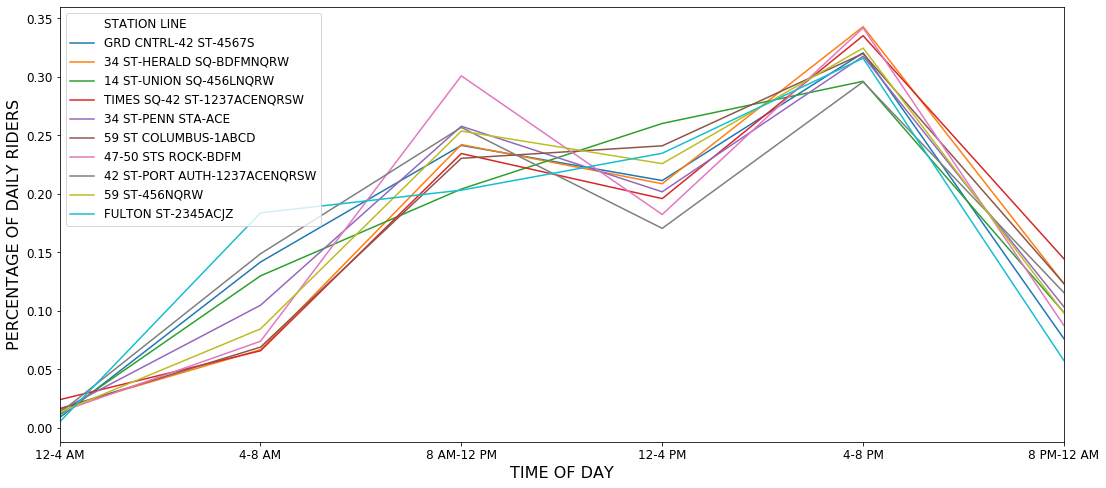

In [20]:
import seaborn as sns
plt.figure(figsize=(18,8))
font = {'size':12}
plt.rc('font', **font) 
plt.xticks([0.0,4.0,8.0,12.0,16.0,20.0],['12-4 AM', '4-8 AM', '8 AM-12 PM', '12-4 PM', '4-8 PM', '8 PM-12 AM'])
# plt.xticks(['12-4 AM', '4-8 AM', '8 AM-12 PM', '12-4 PM', '4-8 PM', '8 PM-12 AM'])

sns.lineplot(data=top_station_hourly, x='HOUR', y='RELATIVE NET MOVEMENT', hue='STATION LINE', markers=True)
plt.xlim(0,20)
plt.legend(loc=2)
plt.xlabel('TIME OF DAY', size=16)
plt.ylabel('PERCENTAGE OF DAILY RIDERS', size=16)
plt.savefig("Time_of_day3.png")

In [ ]:
dfhourly.head()

In [21]:
dfhourtop=dfhour[dfhour['STATION LINE'].isin(topstations)]
topcounts=dfhourtop['TIME'].value_counts()
topcounts=topcounts[topcounts>100]
print(topcounts)

NameError: name 'dfhour' is not defined

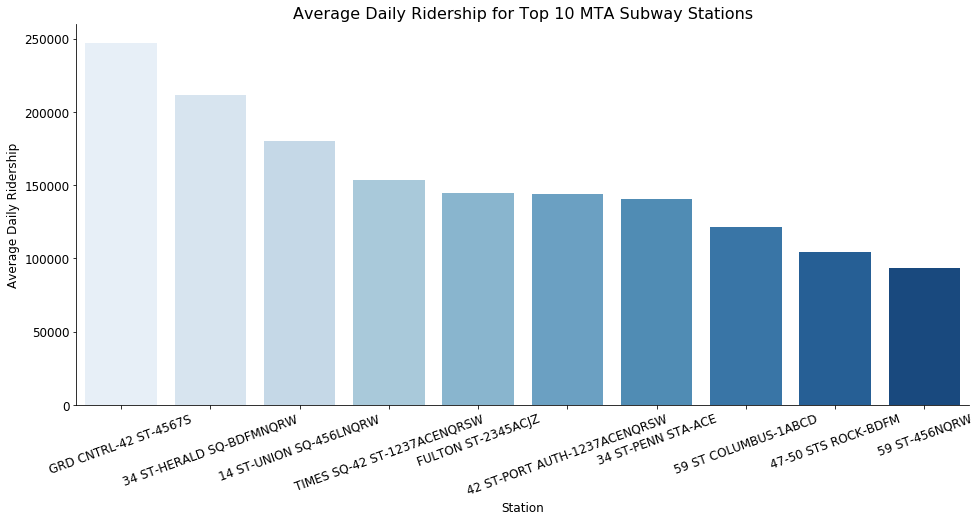

In [24]:
import seaborn as sns
plt.figure(figsize=[16,7])
font={'size':12}
plt.rc('font', **font) 
sns.barplot(x ='STATION LINE',y='NET MOVEMENT',data=top10daily,palette=sns.color_palette("Blues",10));
plt.xticks(rotation=20);
plt.xlabel('Station')
plt.ylabel('Average Daily Ridership')
plt.title('Average Daily Ridership for Top 10 MTA Subway Stations',size=16)
sns.despine()
plt.savefig("Average_daily_ridership.png")

In [ ]:
#Average Weekend vs Weekday Ridership per day

In [ ]:
#Challenge 10
plt.hist(np.log10(totaldf),20);
plt.xlabel('Total number of entrants on a log10 scale')
plt.ylabel('Number of stations')
plt.title('Distribution of number of entrants for a station during 4 weeks in April/May');


In [23]:

#For missing dates, create a new diff column for number of days between row, then we can divide the net entries by
#the number of days
df.groupby(['C/A','UNIT','SCP','STATION LINE','DATE'])['ENTRIES'].count().sort_values()

C/A    UNIT  SCP       STATION LINE          DATE      
PTH03  R552  00-00-02  JOURNAL SQUARE-1      2019-05-06    1
PTH13  R541  00-00-06  THIRTY ST-1           2019-05-23    1
PTH11  R545  00-04-04  14TH STREET-1         2019-05-22    1
                                             2019-05-15    1
             00-04-03  14TH STREET-1         2019-05-22    1
                                                          ..
N110   R283  00-06-01  LAFAYETTE AV-C        2019-05-17    6
G009   R151  02-00-04  CONEY IS-STILLW-DFNQ  2019-05-16    7
             02-00-03  CONEY IS-STILLW-DFNQ  2019-05-16    7
N525   R142  01-00-03  DELANCEY/ESSEX-FJMZ   2019-05-11    7
             01-00-04  DELANCEY/ESSEX-FJMZ   2019-05-11    7
Name: ENTRIES, Length: 124464, dtype: int64

In [ ]:
df[(df['C/A']=='A038')&(df['UNIT']=='R085')&(df['SCP']=='00-06-00')]

In [ ]:
df[(df['C/A']=='N508')&(df['UNIT']=='R453')&(df['SCP']=='00-00-00')]['DATE'].value_counts()